## House Prices - Advanced Regression Techniques

****** HERE WILL BE ID *******

### TL;DR

### Part 1 Imports and Definitions


In [1529]:
# import numpy, matplotlib, etc. 
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import sweetviz as sw
import os
from tqdm import tqdm


# sklearn imports
from sklearn import metrics
from sklearn import pipeline
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import neural_network
from sklearn import model_selection
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split


# define plt settings
sns.set_theme()
plt.rcParams["font.size"] = 20
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["legend.fontsize"] = 20
plt.rcParams["legend.markerscale"] = 1.5
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams["legend.title_fontsize"] = 20


- define the input and output folders


In [1530]:
input_folder = "input/"

train_data_path = os.path.join(input_folder, "train.csv")
test_data_path = os.path.join(input_folder, "test.csv")

  - define the show graphs variable


In [1531]:
SHOW_GRAPHS = True

#### Load the traning data
  - Load the csv data to variables


In [1532]:
train_data = pd.read_csv(train_data_path)

test_data = pd.read_csv(test_data_path)

# display the first few rows of the data
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Part 2 Data Investigation EDA


#### Data Cleaning

- Remove the id column


In [1533]:
# Drop the "Id" column from the train_data DataFrame
train_data = train_data.drop("Id", axis=1)

# Drop the "Id" column from the test_data DataFrame
test_id = test_data["Id"]
test_data = test_data.drop("Id", axis=1)


train_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


- Count the number of feuatures

In [1534]:
print(f"Number of features: {train_data.shape[1]}")

Number of features: 80


Get summary statistics for the training dataset show only the numerical columns


In [1535]:
train_data.describe()


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


- Get the data types of the columns in the training dataset


In [1536]:
display(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

None

We can see that most of the data is object

- Check for missing values

In [1537]:
def show_missing_data_with_percentage(data):
    print("Missing values in the dataset:")
    print("-----------------------------------------")
    print("Total Rows: ", len(data))
    print("_________________________________________")
    # Display missing values in each column of the training dataset
    missing_values = data.isnull().sum()
    missing_percentage = (missing_values / len(train_data)) * 100
    missing_data = pd.concat([missing_values, missing_percentage], axis=1, keys=['Missing Values', 'Percentage'])
    missing_data.sort_values(by='Missing Values', ascending=False, inplace=True)
    print(missing_data.head(20))
    
    print("\n\nTotal missing values: ", missing_data['Missing Values'].sum())
    
    


In [1538]:
# Display missing values in the training dataset
show_missing_data_with_percentage(train_data)

Missing values in the dataset:
-----------------------------------------
Total Rows:  1460
_________________________________________
              Missing Values  Percentage
PoolQC                  1453   99.520548
MiscFeature             1406   96.301370
Alley                   1369   93.767123
Fence                   1179   80.753425
MasVnrType               872   59.726027
FireplaceQu              690   47.260274
LotFrontage              259   17.739726
GarageYrBlt               81    5.547945
GarageCond                81    5.547945
GarageType                81    5.547945
GarageFinish              81    5.547945
GarageQual                81    5.547945
BsmtExposure              38    2.602740
BsmtFinType2              38    2.602740
BsmtCond                  37    2.534247
BsmtQual                  37    2.534247
BsmtFinType1              37    2.534247
MasVnrArea                 8    0.547945
Electrical                 1    0.068493
MSSubClass                 0    0.000000


Tota

We can see that the columns "Alley", "PoolQC", "Fence", "MiscFeature" have a lot of missing values.

- Handle the missing data<br><br>
First step to remove highly missing features (by threshold)

In [1539]:
def drop_highly_missing_features(data, fetures_to_drop):
    data = data.drop(fetures_to_drop, axis=1)
    return data


def find_features_with_missing_values_threshold(data, threshold):
    missing_values = data.isnull().sum()
    missing_percentage = (missing_values / len(train_data)) * 100
    missing_data = pd.concat([missing_values, missing_percentage], axis=1, keys=['Missing Values', 'Percentage'])
    missing_data.sort_values(by='Missing Values', ascending=False, inplace=True)
    features_to_drop = missing_data[missing_data['Percentage'] > threshold].index
    return features_to_drop


In [1540]:
# Set the threshold for missing values to remove
threshold = 80
# for 80 it return # ["Alley", "PoolQC", "Fence", "MiscFeature"]
drop_features = find_features_with_missing_values_threshold(train_data, threshold) 


train_data = drop_highly_missing_features(train_data, drop_features)

test_data = drop_highly_missing_features(test_data, drop_features)

print("Remove this features: ", drop_features)

Remove this features:  Index(['PoolQC', 'MiscFeature', 'Alley', 'Fence'], dtype='object')


In [1541]:
show_missing_data_with_percentage(train_data)

Missing values in the dataset:
-----------------------------------------
Total Rows:  1460
_________________________________________
              Missing Values  Percentage
MasVnrType               872   59.726027
FireplaceQu              690   47.260274
LotFrontage              259   17.739726
GarageType                81    5.547945
GarageYrBlt               81    5.547945
GarageFinish              81    5.547945
GarageQual                81    5.547945
GarageCond                81    5.547945
BsmtExposure              38    2.602740
BsmtFinType2              38    2.602740
BsmtQual                  37    2.534247
BsmtCond                  37    2.534247
BsmtFinType1              37    2.534247
MasVnrArea                 8    0.547945
Electrical                 1    0.068493
Fireplaces                 0    0.000000
KitchenQual                0    0.000000
KitchenAbvGr               0    0.000000
BedroomAbvGr               0    0.000000
HalfBath                   0    0.000000


Tota

Handling Missing Values for Numerical Features

In [1542]:
# fill missing numerical values with median
def handle_missing_values_numerical(data):
    for column in data.select_dtypes(include=[np.number]).columns:
        data[column].fillna(data[column].median(), inplace=True)
    return data

Handling Missing Values for Categorical Features

In [1543]:
# Fill missing categorical values with most frequent value
def handle_missing_values_categorical(data):
    for column in data.select_dtypes(include=[object]).columns:
        data[column].fillna(data[column].mode()[0], inplace=True)
    return data

One function to handle the missing values

In [1544]:
def handle_missing_values(data):
    data = handle_missing_values_numerical(data)
    data = handle_missing_values_categorical(data)
    return data

In [1545]:
# fill the missing values in the train data
train_data = handle_missing_values(train_data)

# fill the missing values in the test data
test_data = handle_missing_values(test_data)

Verify No More Missing Values

In [1546]:
print("\nMissing values in the training dataset after filling:")
print(train_data.isnull().sum().sum())

print("\nMissing values in the test dataset after filling:")
print(test_data.isnull().sum().sum())



Missing values in the training dataset after filling:
0

Missing values in the test dataset after filling:
0


In [1547]:
train_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000


Convert Categorical Features to Numeric Using One-Hot Encoding

In [1548]:
print("Data types in training data:")
print(train_data.dtypes)


Data types in training data:
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 76, dtype: object


In [1549]:
# Identify categorical columns
categorical_columns = train_data.select_dtypes(include=['object']).columns

# Use one hot encoding to convert categorical columns to numerical columns
train_data_encoded = pd.get_dummies(train_data, columns=categorical_columns)
test_data_encoded = pd.get_dummies(test_data, columns=categorical_columns)

# Save the target variable (SalePrice) and then drop it from train_data_encoded before alignment
sale_price = train_data_encoded['SalePrice']
train_data_encoded = train_data_encoded.drop('SalePrice', axis=1)

# Align train and test data to ensure they have the same columns
train_data_encoded, test_data_encoded = train_data_encoded.align(test_data_encoded, join='inner', axis=1)

# Reattach the SalePrice column to train_data_encoded
train_data_encoded['SalePrice'] = sale_price


In [1550]:
# Reassigning the encoded DataFrame back to the original variable
train_data = train_data_encoded
test_data = test_data_encoded

# Display the first few rows of the training data after encoding
train_data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,False,False,True,False,False,False,False,True,False,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,False,False,True,False,False,False,False,True,False,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,False,False,True,False,False,False,False,True,False,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,False,False,True,True,False,False,False,False,False,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,False,False,True,False,False,False,False,True,False,250000


#### Feature Analysis & Visualization 

Descriptive Statistics

In [1551]:
desc_stats = train_data.describe()
print("Descriptive Statistics:\n", desc_stats)


Descriptive Statistics:
         MSSubClass  LotFrontage        LotArea  OverallQual  OverallCond  \
count  1460.000000  1460.000000    1460.000000  1460.000000  1460.000000   
mean     56.897260    69.863699   10516.828082     6.099315     5.575342   
std      42.300571    22.027677    9981.264932     1.382997     1.112799   
min      20.000000    21.000000    1300.000000     1.000000     1.000000   
25%      20.000000    60.000000    7553.500000     5.000000     5.000000   
50%      50.000000    69.000000    9478.500000     6.000000     5.000000   
75%      70.000000    79.000000   11601.500000     7.000000     6.000000   
max     190.000000   313.000000  215245.000000    10.000000     9.000000   

         YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1   BsmtFinSF2  ...  \
count  1460.000000   1460.000000  1460.000000  1460.000000  1460.000000  ...   
mean   1971.267808   1984.865753   103.117123   443.639726    46.549315  ...   
std      30.202904     20.645407   180.731373   45

Histogram for SalePrice

In [1552]:
if SHOW_GRAPHS:
    fig = px.histogram(train_data, x='SalePrice', title='Distribution of SalePrice')
    fig.show()

We can see the distribution of SalePrice

- Box plot for SalePrice

In [1553]:
if SHOW_GRAPHS:
    fig = px.box(train_data, y='SalePrice', title='Boxplot of SalePrice')
    fig.show()

GrLivArea: Above grade (ground) living area square feet

In [1554]:
if SHOW_GRAPHS:
    fig = px.scatter(train_data, x='GrLivArea', y='SalePrice', title='GrLivArea vs SalePrice')
    fig.show()


In [1555]:
if SHOW_GRAPHS:
    fig = px.scatter(train_data, x='GrLivArea', y='SalePrice', marginal_x='histogram', marginal_y='histogram', title='Joint Plot of GrLivArea vs SalePrice')
    fig.show()

TotalBsmtSF: Total square feet of basement area

In [1556]:
if SHOW_GRAPHS:
    fig = px.scatter(train_data, x='TotalBsmtSF', y='SalePrice', title='TotalBsmtSF vs SalePrice')
    fig.show()

OverallQual: Rates the overall material and finish of the house

In [1557]:

if SHOW_GRAPHS:
    overall_qual_mean = train_data.groupby('OverallQual')['SalePrice'].mean()
    fig = px.bar(overall_qual_mean, x=overall_qual_mean.index, y='SalePrice', title='OverallQual vs SalePrice')
    fig.add_trace(go.Scatter(x=overall_qual_mean.index, y=overall_qual_mean.values, mode='lines', name='lines'))
    fig.show()


We calculate the correlation of each feature with SalePrice and sort them to identify the strongest relationships.

In [1558]:
correlation_matrix = train_data.corr()
# use abs with the correlation matrix
correlation_matrix = correlation_matrix.abs()
correlation_with_target = correlation_matrix['SalePrice'].sort_values(ascending=False)


- Change N to the number of top features you want to analyze 

In [1559]:
N = 10
top_features = correlation_with_target.index[1:N+1] 
filtered_data = train_data[top_features.to_list() + ['SalePrice']]


Top correlation with SalePrice

In [1560]:
print(f"Top {N} features with the highest correlation with SalePrice:")
print(correlation_with_target.head(N + 1))

Top 10 features with the highest correlation with SalePrice:
SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
ExterQual_TA    0.589044
FullBath        0.560664
BsmtQual_Ex     0.553105
TotRmsAbvGrd    0.533723
Name: SalePrice, dtype: float64


Descriptive Statistics with the N Top correlation

In [1561]:
desc_stats = filtered_data.describe()
print("Descriptive Statistics for Top Features:\n", desc_stats)


Descriptive Statistics for Top Features:
        OverallQual    GrLivArea   GarageCars   GarageArea  TotalBsmtSF  \
count  1460.000000  1460.000000  1460.000000  1460.000000  1460.000000   
mean      6.099315  1515.463699     1.767123   472.980137  1057.429452   
std       1.382997   525.480383     0.747315   213.804841   438.705324   
min       1.000000   334.000000     0.000000     0.000000     0.000000   
25%       5.000000  1129.500000     1.000000   334.500000   795.750000   
50%       6.000000  1464.000000     2.000000   480.000000   991.500000   
75%       7.000000  1776.750000     2.000000   576.000000  1298.250000   
max      10.000000  5642.000000     4.000000  1418.000000  6110.000000   

          1stFlrSF     FullBath  TotRmsAbvGrd      SalePrice  
count  1460.000000  1460.000000   1460.000000    1460.000000  
mean   1162.626712     1.565068      6.517808  180921.195890  
std     386.587738     0.550916      1.625393   79442.502883  
min     334.000000     0.000000      2.

Pairplot Visualizing Correlation

In [1562]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_and_calculate_statistics(filtered_data):
    """
    For each feature in the filtered_data (excluding 'SalePrice'), plots the feature against 'SalePrice'
    and calculates relevant statistics.
    
    Parameters:
    - filtered_data: DataFrame containing the top N features most correlated with 'SalePrice' and 'SalePrice' itself.
    """
    # Exclude 'SalePrice' from the features to plot
    features = [column for column in filtered_data.columns if column != 'SalePrice']
    
    for feature in features:
        # Plotting
        plt.figure(figsize=(10, 6))
        if filtered_data[feature].dtype == 'object' or len(filtered_data[feature].unique()) <= 20:
            # For categorical features or numerical features with few unique values, use boxplot
            sns.boxplot(x=feature, y='SalePrice', data=filtered_data)
        else:
            # For continuous numerical features, use scatterplot
            sns.scatterplot(x=feature, y='SalePrice', data=filtered_data)
        plt.title(f'Sale Price by {feature}')
        plt.show()
        
        # Calculating and displaying statistics
        if filtered_data[feature].dtype == 'object' or len(filtered_data[feature].unique()) <= 20:
            # For categorical features, display mean SalePrice for each category
            mean_prices = filtered_data.groupby(feature)['SalePrice'].mean().sort_values(ascending=False)
            print(f"Mean Sale Price for each {feature}:")
            print(mean_prices)
        else:
            # For continuous numerical features, consider displaying correlation or other relevant statistics
            correlation = filtered_data[[feature, 'SalePrice']].corr().iloc[0, 1]
            print(f"Correlation between {feature} and Sale Price: {correlation:.2f}")


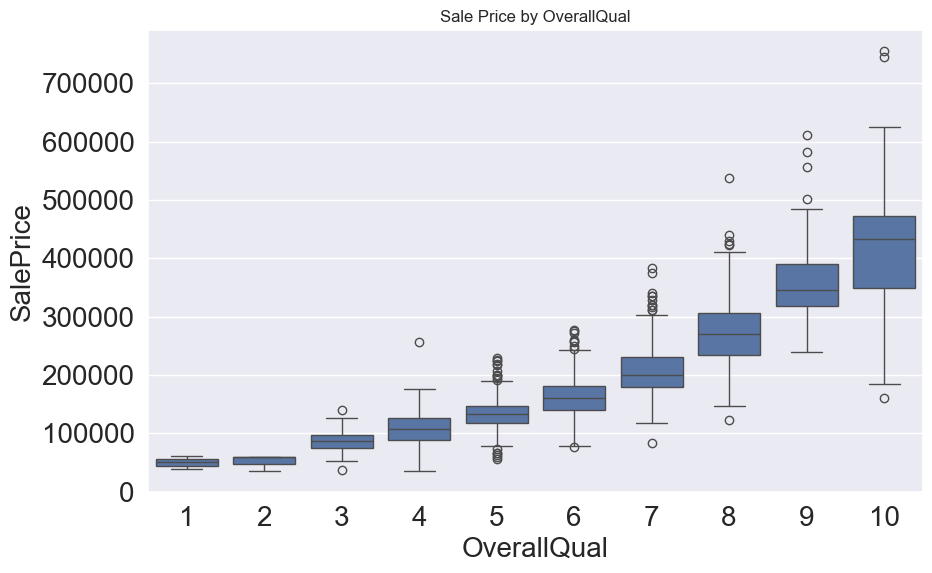

Mean Sale Price for each OverallQual:
OverallQual
10    438588.388889
9     367513.023256
8     274735.535714
7     207716.423197
6     161603.034759
5     133523.347607
4     108420.655172
3      87473.750000
2      51770.333333
1      50150.000000
Name: SalePrice, dtype: float64


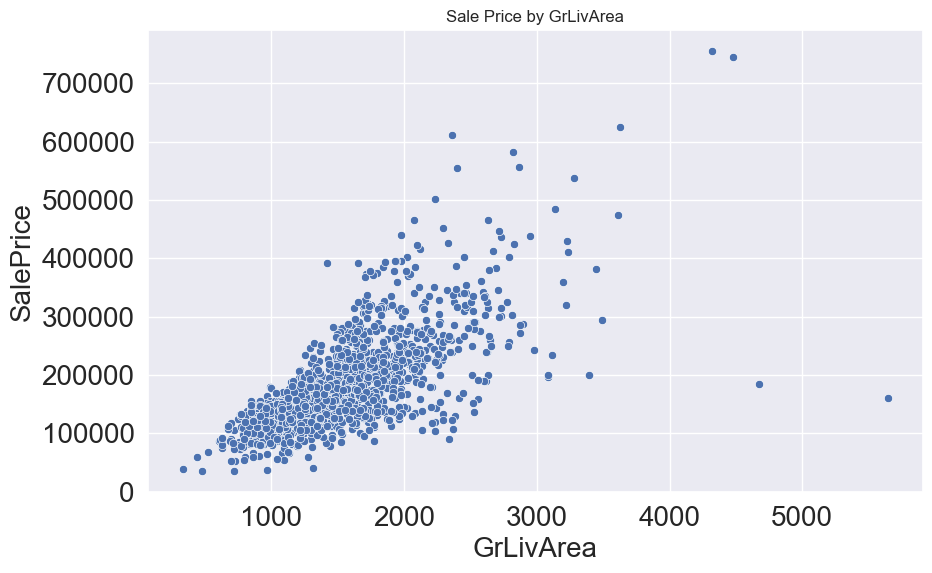

Correlation between GrLivArea and Sale Price: 0.71


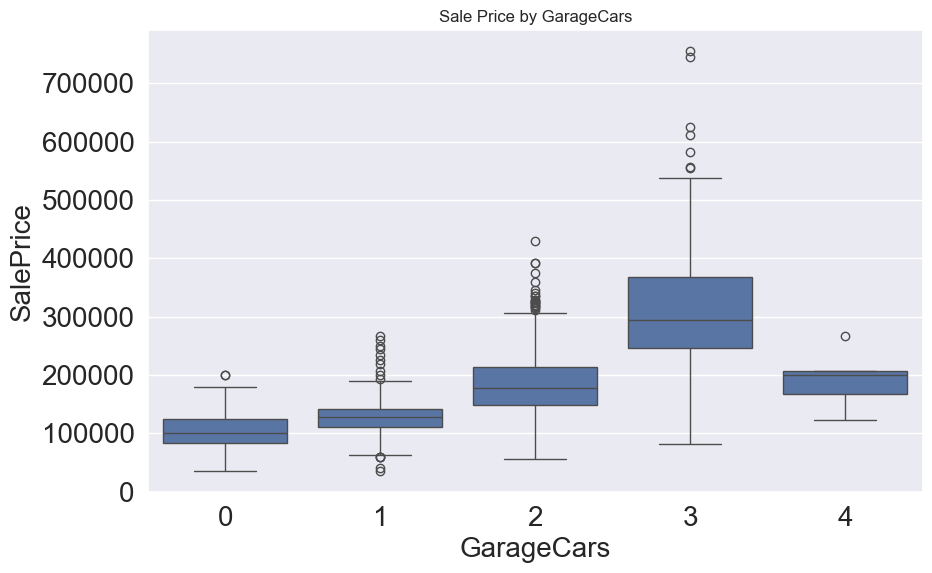

Mean Sale Price for each GarageCars:
GarageCars
3    309636.121547
4    192655.800000
2    183851.663835
1    128116.688347
0    103317.283951
Name: SalePrice, dtype: float64


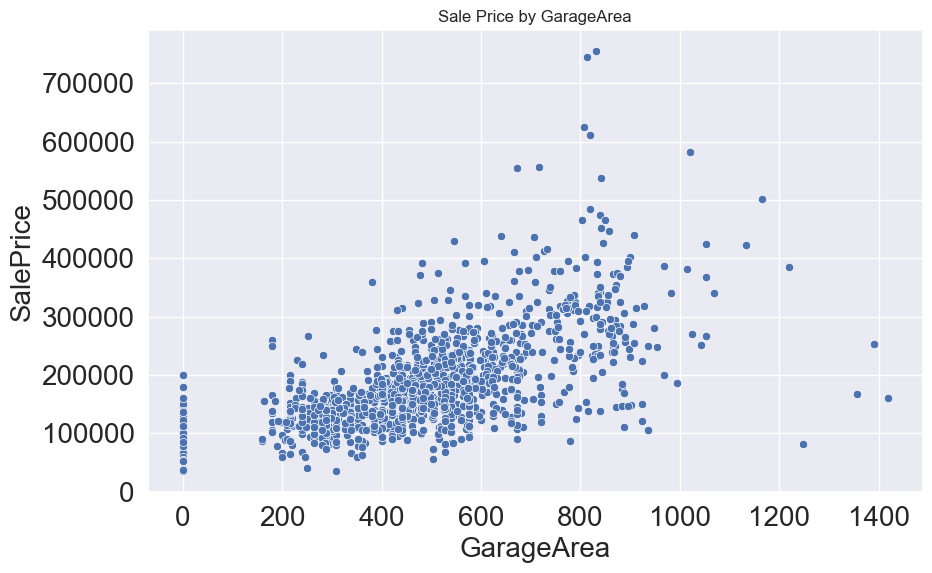

Correlation between GarageArea and Sale Price: 0.62


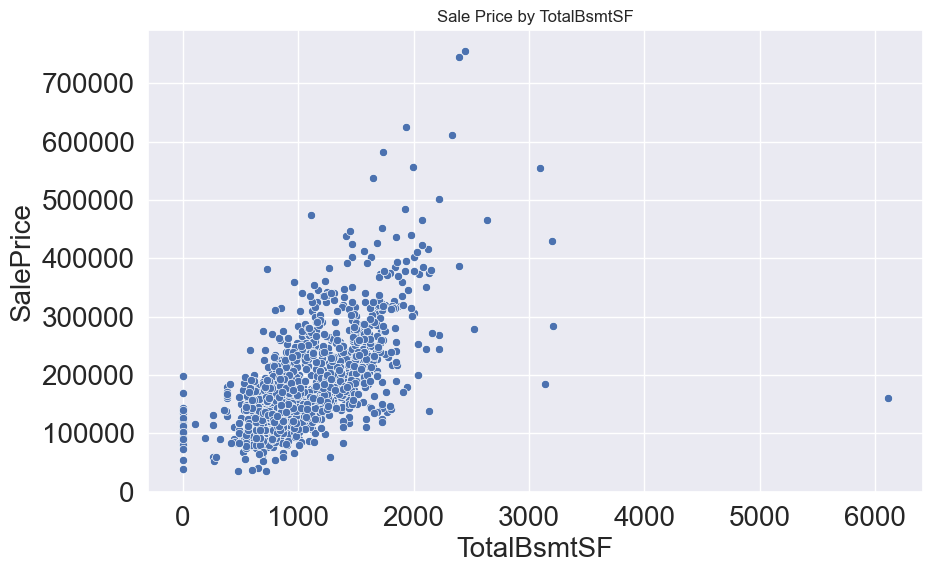

Correlation between TotalBsmtSF and Sale Price: 0.61


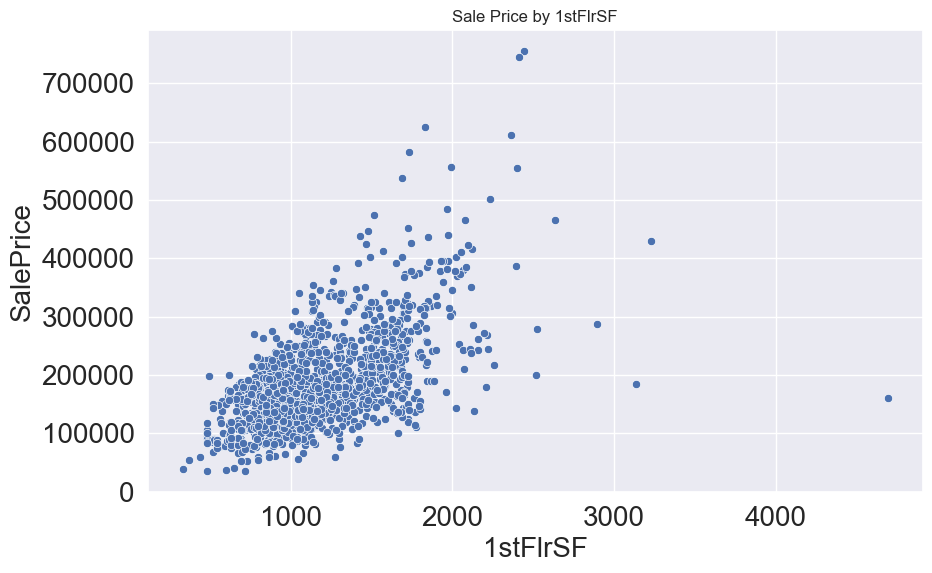

Correlation between 1stFlrSF and Sale Price: 0.61


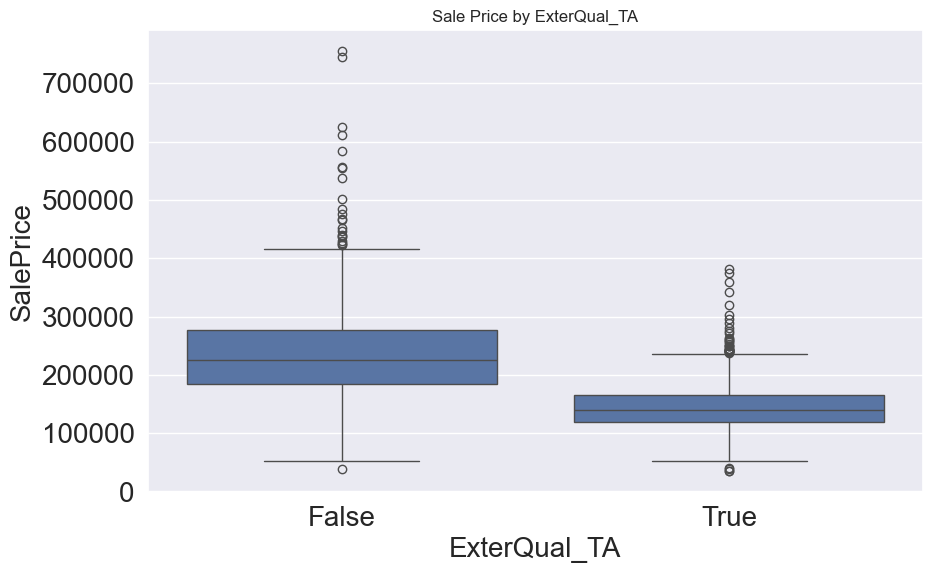

Mean Sale Price for each ExterQual_TA:
ExterQual_TA
False    240743.169675
True     144341.313466
Name: SalePrice, dtype: float64


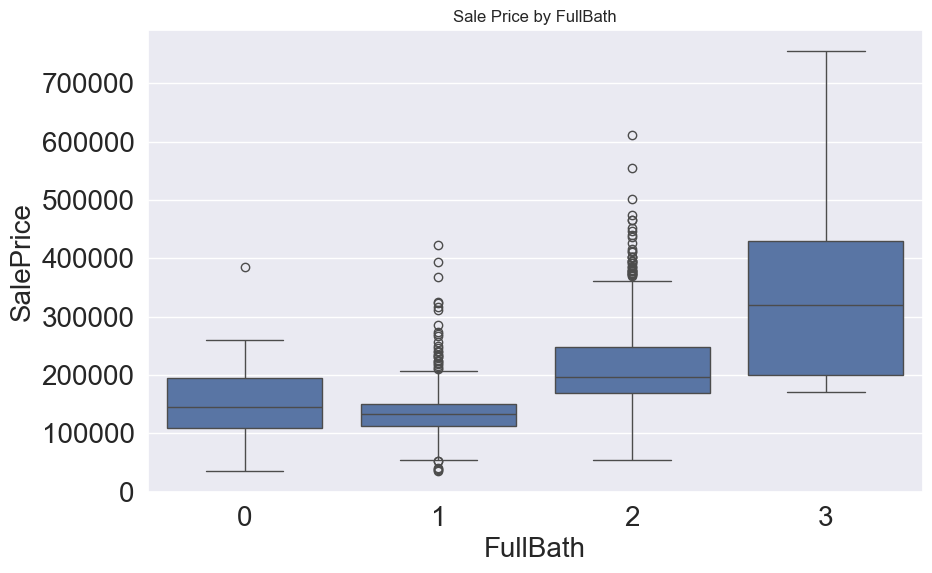

Mean Sale Price for each FullBath:
FullBath
3    347822.909091
2    213009.825521
0    165200.888889
1    134751.440000
Name: SalePrice, dtype: float64


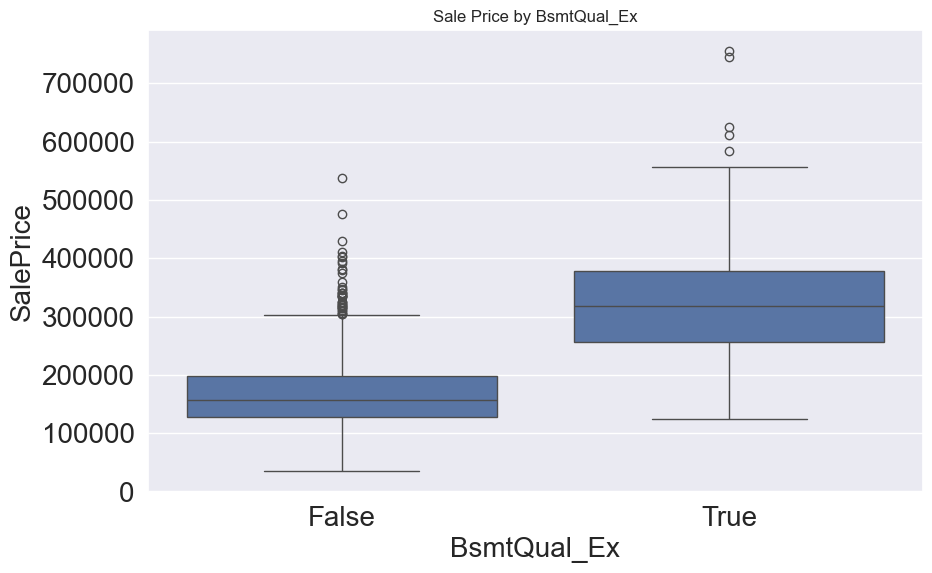

Mean Sale Price for each BsmtQual_Ex:
BsmtQual_Ex
True     327041.041322
False    167716.938013
Name: SalePrice, dtype: float64


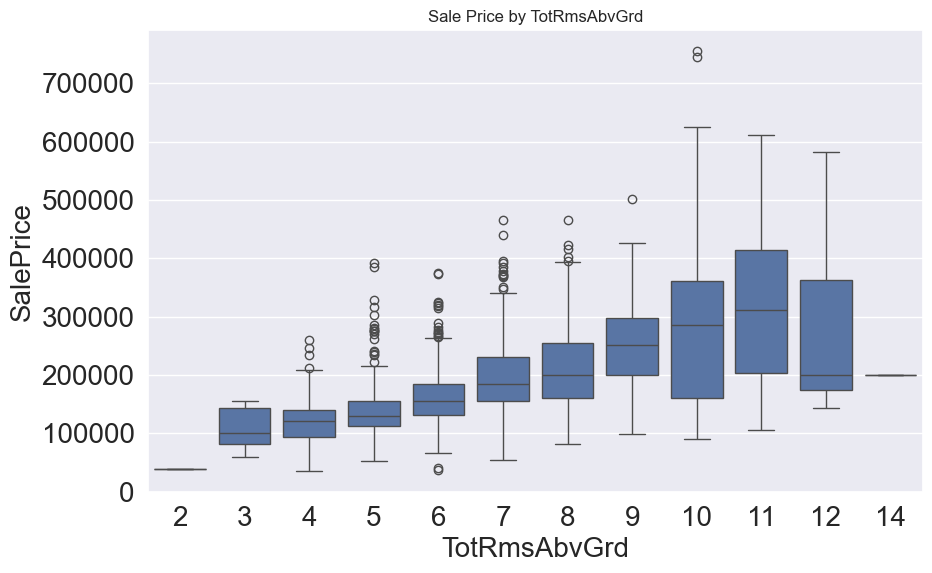

Mean Sale Price for each TotRmsAbvGrd:
TotRmsAbvGrd
11    318022.000000
10    296279.170213
12    280971.454545
9     252988.173333
8     213427.529412
14    200000.000000
7     196666.784195
6     161303.296020
5     141550.749091
4     122844.628866
3     111217.647059
2      39300.000000
Name: SalePrice, dtype: float64


In [1563]:
if SHOW_GRAPHS:
    plot_and_calculate_statistics(filtered_data)

Heatmap for correlation matrix


In [1564]:
import plotly.graph_objects as go

def show_top_correlated_features(train_data, n):
    """
    Displays an interactive heatmap for the top n features most correlated with 'SalePrice', including 'SalePrice' at the most right, with annotations for each cell, using Plotly.
    
    Parameters:
    - train_data: DataFrame containing the training data.
    - n: The number of top features to consider for the heatmap.
    """
    # Calculate the correlation matrix
    correlation_matrix = train_data.corr()
    
    # Find the top n features most correlated with 'SalePrice', excluding 'SalePrice' itself
    top_n_features = correlation_matrix['SalePrice'].abs().sort_values(ascending=False)[1:n+1].index
    
    # Ensure 'SalePrice' is at the end of the list of features to display
    features_to_display = list(top_n_features) + ['SalePrice'] 
    
    # Filter the correlation matrix to include only the selected features
    filtered_corr_matrix = train_data[features_to_display].corr()
    
    # Plotting
    fig = go.Figure(data=go.Heatmap(
        z=filtered_corr_matrix.values,
        x=filtered_corr_matrix.columns,
        y=filtered_corr_matrix.index,
        colorscale='Viridis',
        colorbar=dict(title='Correlation'),
        text=[["{:.2f}".format(val) for val in row] for row in filtered_corr_matrix.values],  # Annotations
        texttemplate="%{text}",
        hoverinfo="none"  # Disable hover info to only show the annotations
    ))
    
    fig.update_layout(
        title=f'Top {n} Features Correlated with SalePrice (Including SalePrice)',
        xaxis_title="Features",
        yaxis_title="Features",
        xaxis=dict(tickmode="array", tickvals=list(range(len(features_to_display))), ticktext=features_to_display),
        yaxis=dict(tickmode="array", tickvals=list(range(len(features_to_display))), ticktext=features_to_display)
    )
    
    fig.show()

In [1565]:
if SHOW_GRAPHS:
    show_top_correlated_features(filtered_data, N)

#### Feature Engineering